# **FINAL PROJECT**

### Name: Apoorva Asgekar
### GitHub ID: ApoorvaAsgekar
### USC ID : 1019968378

# **1. Identification of Frost in Martian HiRISE Images**

# **(a) Importing Packages**

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import logging
import pandas as pd
import random
import tensorflow as tf
from PIL import Image

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import numpy as np

from sklearn.metrics import classification_report

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


# **(b) Data Exploration and Pre-processing**

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

In [5]:
# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('..\\data\\data')

In [6]:
# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [7]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

In [8]:
# Load the subframe names for the three data subsets
train_ids = load_text_ids('..\\train_source_images.txt')
validate_ids = load_text_ids('..\\val_source_images.txt')
test_ids = load_text_ids('.\\test_source_images.txt')

In [9]:
# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [47]:
def augment_image(img):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.2, 1.0],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
        )
    img= np.array(img)
    img= datagen.random_transform(img)
    return img

def load_and_preprocess_augmentation(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        # Augmentation is performed only during training
        img = augment_image(img)
        img = tf.image.resize(img, [299, 299])

        return img, 1 if label_str == 'frost' else 0
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    y.set_shape([])

    # Wrap the Python function
    return X, y

In [33]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    y.set_shape([])

    return X, y

In [12]:
def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""
    global count
    count = 0
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    count+=1
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

In [48]:
# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

# **(c) Training CNN + MLP**

(i) **Augmentation** - has been included in the load_and_preprocess function in part (b)

(ii) **Training the model**

In [14]:
input_shape = (299, 299, 3)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))  # Assuming binary classification


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 297, 297, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 297, 297, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 146, 146, 64)      2

In [16]:
# Compile the model
from keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
# Define early stopping
es_cb = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,start_from_epoch = 20)

In [18]:
num_epochs = 30

history = model.fit(tf_dataset_train,epochs=num_epochs,validation_data=tf_dataset_val, callbacks=[es_cb])

Epoch 1/30
928/928 [==============================] - 409s 426ms/step - loss: 2.2746 - accuracy: 0.6565 - val_loss: 1.1011 - val_accuracy: 0.8962
Epoch 2/30
928/928 [==============================] - 396s 426ms/step - loss: 0.9703 - accuracy: 0.7146 - val_loss: 2.6729 - val_accuracy: 0.3218
Epoch 3/30
928/928 [==============================] - 392s 422ms/step - loss: 0.8541 - accuracy: 0.7331 - val_loss: 3.1452 - val_accuracy: 0.4681
Epoch 4/30
928/928 [==============================] - 396s 426ms/step - loss: 0.8120 - accuracy: 0.7579 - val_loss: 2.4061 - val_accuracy: 0.3566
Epoch 5/30
928/928 [==============================] - 398s 428ms/step - loss: 0.7706 - accuracy: 0.7837 - val_loss: 0.9158 - val_accuracy: 0.7069
Epoch 6/30
928/928 [==============================] - 390s 420ms/step - loss: 0.7059 - accuracy: 0.8168 - val_loss: 0.7008 - val_accuracy: 0.7507
Epoch 7/30
928/928 [==============================] - 392s 421ms/step - loss: 0.7039 - accuracy: 0.8400 - val_loss: 0.8504 -

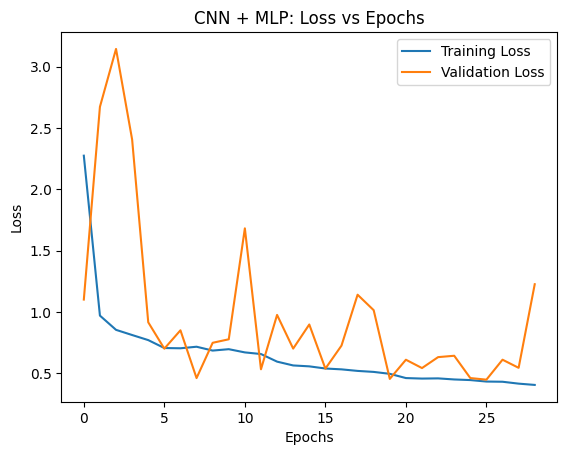

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN + MLP: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(iii) **Evaluation**

In [20]:
all_true_labels = []
all_predicted_labels = []

for batch1 in tf_dataset_test:
    images, labels = batch1
    predicted_probs = model.predict(images,verbose = 0)
    predicted_labels = np.argmax(predicted_probs, axis=1)
    labels = labels.numpy()
    all_true_labels.extend(labels)
    all_predicted_labels.extend(predicted_labels)

print("Classification Report")

print(classification_report(all_true_labels, all_predicted_labels,target_names= ['frost', 'background']))


Classification Report
              precision    recall  f1-score   support

       frost       0.77      0.94      0.84      4418
  background       0.96      0.85      0.90      8405

    accuracy                           0.88     12823
   macro avg       0.86      0.89      0.87     12823
weighted avg       0.89      0.88      0.88     12823



In [21]:
precision = precision_score(all_true_labels, all_predicted_labels, average='binary')
recall = recall_score(all_true_labels, all_predicted_labels, average='binary')
f1 = f1_score(all_true_labels, all_predicted_labels, average='binary')

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1-Score: {f1:.4f}')

Overall Precision: 0.9617
Overall Recall: 0.8504
Overall F1-Score: 0.9026


In [22]:
scores = model.evaluate(tf_dataset_test)

# Print the accuracy score
print('\nAccuracy score of the model: {0:.2f}%'.format(scores[1] * 100))

401/401 [==============================] - 42s 105ms/step - loss: 0.7336 - accuracy: 0.8797

Accuracy score of the model: 87.97%


# **(d) Transfer Learning**

In [23]:
def build_transfer_model(base_model):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    return model


In [35]:
def train_transfer_model(model, train_data, val_data, epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,start_from_epoch = 20)

    adam = Adam(learning_rate=0.0001)

    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, epochs=epochs,validation_data=val_data, callbacks=[early_stopping])

    return history

In [25]:
def evaluate_model(model, test_data):
    predicted_labels = []
    true_labels = []

    for batch in test_data:
        images, labels = batch
        predictions = model.predict(images,verbose = 0)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    scores = model.evaluate(tf_dataset_test)

    print("Classification Report:")

    print(classification_report(true_labels, predicted_labels,target_names= ['frost', 'background']))

    print('\nAccuracy score of the model: {0:.2f}%'.format(scores[1] * 100))

In [26]:
def overallevaluate(model, test_data):
    predicted_labels = []
    true_labels = []

    for batch in test_data:
        images, labels = batch
        predictions = model.predict(images,verbose = 0)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')

    print(f'Overall Precision: {precision:.4f}')
    print(f'Overall Recall: {recall:.4f}')
    print(f'Overall F1-Score: {f1:.4f}')

    return precision,recall,f1

# **EfficientNetB0**

In [27]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model_efficientnet.trainable = False
transfer_model_efficientnet = build_transfer_model(base_model_efficientnet)

16705208/16705208 [==============================] - 1s 0us/step


In [28]:
transfer_model_efficientnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [54]:
history_efficientnet = train_transfer_model(transfer_model_efficientnet, tf_dataset_train, tf_dataset_val)

Epoch 1/30
928/928 [==============================] - 353s 372ms/step - loss: 0.3623 - accuracy: 0.8354 - val_loss: 0.5957 - val_accuracy: 0.7880
Epoch 2/30
928/928 [==============================] - 343s 369ms/step - loss: 0.2380 - accuracy: 0.9006 - val_loss: 0.9630 - val_accuracy: 0.7562
Epoch 3/30
928/928 [==============================] - 345s 371ms/step - loss: 0.2077 - accuracy: 0.9162 - val_loss: 0.8439 - val_accuracy: 0.7758
Epoch 4/30
928/928 [==============================] - 346s 373ms/step - loss: 0.1902 - accuracy: 0.9233 - val_loss: 0.7964 - val_accuracy: 0.7863
Epoch 5/30
928/928 [==============================] - 348s 375ms/step - loss: 0.1725 - accuracy: 0.9299 - val_loss: 0.8582 - val_accuracy: 0.7865
Epoch 6/30
928/928 [==============================] - 348s 375ms/step - loss: 0.1674 - accuracy: 0.9314 - val_loss: 0.9182 - val_accuracy: 0.7938
Epoch 7/30
928/928 [==============================] - 346s 373ms/step - loss: 0.1584 - accuracy: 0.9369 - val_loss: 1.0166 -

In [55]:
scores_eff = transfer_model_efficientnet.evaluate(tf_dataset_test,verbose = 0)
evaluate_model(transfer_model_efficientnet, tf_dataset_test)

401/401 [==============================] - 52s 129ms/step - loss: 0.2767 - accuracy: 0.9102
Classification Report:
              precision    recall  f1-score   support

       frost       0.86      0.88      0.87      4418
  background       0.94      0.93      0.93      8405

    accuracy                           0.91     12823
   macro avg       0.90      0.90      0.90     12823
weighted avg       0.91      0.91      0.91     12823


Accuracy score of the model: 91.02%


In [56]:
precision_eff,recall_eff,f1_eff = overallevaluate(transfer_model_efficientnet, tf_dataset_test)

Overall Precision: 0.9357
Overall Recall: 0.9266
Overall F1-Score: 0.9311


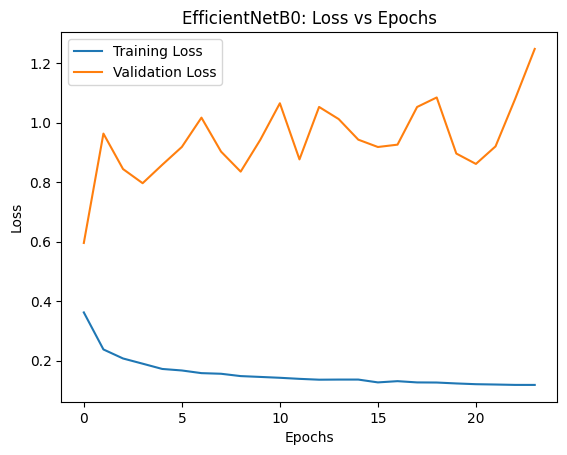

In [57]:
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **ResNet50**

In [38]:
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model_resnet50.trainable = False
transfer_model_resnet50 = build_transfer_model(base_model_resnet50)

94765736/94765736 [==============================] - 3s 0us/step


In [39]:
transfer_model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [40]:
history_resnet50 = train_transfer_model(transfer_model_resnet50, tf_dataset_train, tf_dataset_val)

Epoch 1/30
928/928 [==============================] - 403s 428ms/step - loss: 0.3196 - accuracy: 0.8655 - val_loss: 0.6704 - val_accuracy: 0.7769
Epoch 2/30
928/928 [==============================] - 394s 423ms/step - loss: 0.2090 - accuracy: 0.9157 - val_loss: 0.7358 - val_accuracy: 0.7694
Epoch 3/30
928/928 [==============================] - 393s 422ms/step - loss: 0.1755 - accuracy: 0.9292 - val_loss: 0.7913 - val_accuracy: 0.7422
Epoch 4/30
928/928 [==============================] - 384s 413ms/step - loss: 0.1687 - accuracy: 0.9324 - val_loss: 0.9146 - val_accuracy: 0.7306
Epoch 5/30
928/928 [==============================] - 388s 418ms/step - loss: 0.1477 - accuracy: 0.9404 - val_loss: 0.6969 - val_accuracy: 0.7718
Epoch 6/30
928/928 [==============================] - 388s 417ms/step - loss: 0.1425 - accuracy: 0.9434 - val_loss: 0.7232 - val_accuracy: 0.7779
Epoch 7/30
928/928 [==============================] - 385s 414ms/step - loss: 0.1344 - accuracy: 0.9470 - val_loss: 0.8683 -

In [41]:
scores_res = transfer_model_resnet50.evaluate(tf_dataset_test,verbose = 0)
evaluate_model(transfer_model_resnet50, tf_dataset_test)

401/401 [==============================] - 59s 147ms/step - loss: 0.4276 - accuracy: 0.8574
Classification Report:
              precision    recall  f1-score   support

       frost       0.96      0.61      0.75      4418
  background       0.83      0.99      0.90      8405

    accuracy                           0.86     12823
   macro avg       0.89      0.80      0.82     12823
weighted avg       0.87      0.86      0.85     12823


Accuracy score of the model: 85.74%


In [42]:
precision_res,recall_res,f1_res = overallevaluate(transfer_model_resnet50, tf_dataset_test)

Overall Precision: 0.8285
Overall Recall: 0.9867
Overall F1-Score: 0.9007


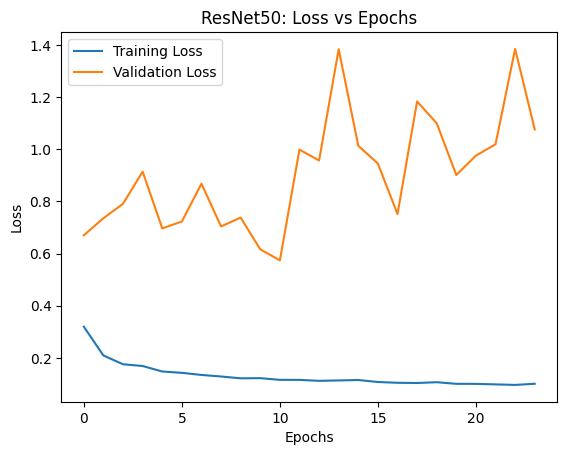

In [44]:
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **VGG16**


In [45]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model_vgg16.trainable = False
transfer_model_vgg16 = build_transfer_model(base_model_vgg16)

58889256/58889256 [==============================] - 2s 0us/step


In [46]:
transfer_model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [49]:
history_vgg16 = train_transfer_model(transfer_model_vgg16, tf_dataset_train, tf_dataset_val)

Epoch 1/30
928/928 [==============================] - 398s 424ms/step - loss: 0.4602 - accuracy: 0.7925 - val_loss: 0.8065 - val_accuracy: 0.7190
Epoch 2/30
928/928 [==============================] - 392s 422ms/step - loss: 0.2938 - accuracy: 0.8773 - val_loss: 0.7478 - val_accuracy: 0.7240
Epoch 3/30
928/928 [==============================] - 393s 422ms/step - loss: 0.2559 - accuracy: 0.8961 - val_loss: 0.8424 - val_accuracy: 0.6919
Epoch 4/30
928/928 [==============================] - 392s 421ms/step - loss: 0.2262 - accuracy: 0.9067 - val_loss: 1.0351 - val_accuracy: 0.6580
Epoch 5/30
928/928 [==============================] - 392s 422ms/step - loss: 0.2053 - accuracy: 0.9168 - val_loss: 0.8176 - val_accuracy: 0.7074
Epoch 6/30
928/928 [==============================] - 391s 421ms/step - loss: 0.1946 - accuracy: 0.9233 - val_loss: 0.7709 - val_accuracy: 0.7200
Epoch 7/30
928/928 [==============================] - 391s 420ms/step - loss: 0.1859 - accuracy: 0.9257 - val_loss: 1.0524 -

In [50]:
scores_vgg = transfer_model_vgg16.evaluate(tf_dataset_test,verbose = 0)
evaluate_model(transfer_model_vgg16, tf_dataset_test)

401/401 [==============================] - 64s 158ms/step - loss: 0.4344 - accuracy: 0.8758
Classification Report:
              precision    recall  f1-score   support

       frost       0.82      0.82      0.82      4418
  background       0.90      0.91      0.91      8405

    accuracy                           0.88     12823
   macro avg       0.86      0.86      0.86     12823
weighted avg       0.88      0.88      0.88     12823


Accuracy score of the model: 87.58%


In [51]:
precision_vgg,recall_vgg,f1_vgg = overallevaluate(transfer_model_vgg16, tf_dataset_test)

Overall Precision: 0.9034
Overall Recall: 0.9077
Overall F1-Score: 0.9055


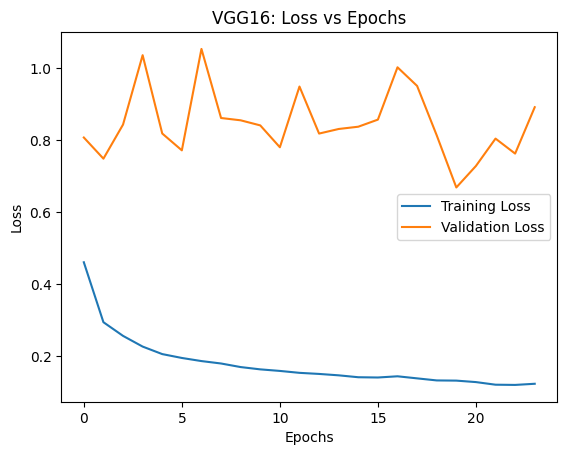

In [52]:
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16: Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Comparison between models**

In [58]:
data = [['1','CNN + MLP',round(precision,4),round(recall,4),round(f1,4),round(scores[1],4)],['2','Transfer Learning using EfficientNetB0',round(precision_eff,4),round(recall_eff,4),round(f1_eff,4),round(scores_eff[1],4)],['3','Transfer Learning using ResNet50',round(precision_res,4),round(recall_res,4),round(f1_res,4),round(scores_res[1],4)],['4','Transfer Learning using VGG16',round(precision_vgg,4),round(recall_vgg,4),round(f1_vgg,4),round(scores_vgg[1],4)]]
df5 = pd.DataFrame(data, columns = ['SNo.', 'Model','Precision','Recall','F1-Score','Testing Accuracy of model'])
df5

,SNo.,Model,Precision,Recall,F1-Score,Testing Accuracy of model
0,1,CNN + MLP,0.9617,0.8504,0.9026,0.8797
1,2,Transfer Learning using EfficientNetB0,0.9357,0.9266,0.9311,0.9102
2,3,Transfer Learning using ResNet50,0.8285,0.9867,0.9007,0.8574
3,4,Transfer Learning using VGG16,0.9034,0.9077,0.9055,0.8758


From the above comparisson table we observe the following:
1. The EfficientNetB0 transfer learning model performs best amongst the rest of the models exhibiting a good test accuracy with high precision, recall, and F1-score. .

2. The CNN+MLP model has a high precision score which shows that it mostly predicts the posititive class (frost) correctly, but  a lower recall score shows that it may missclassify some of the positive class instances. The F1-score is balanced for the model with a good testing accuracy.

3. VGG16 transfer learning model exhibits a good test accuracy with steady precision, recall, and F1-score.

4. ResNet50 transfer learning model also performs with a decent test accuracy but we observe a lower precision score whe compared to other models.




